## Table of contents:
* Initial Setup
* Data Loading and Preprocessing
    * Data Variables
* Model Instantiation
* Optimizer and Scheduler
* Train and Evaluation Loop
    * Save the model and plot the losses (**1 Point**)
* Test Loop  
* Human Pose Visualization (**2 Points**)
* Report and Parameter Fine-Tuning Analysis  (**4 Points**)
* Calculating MPJPE for a Specific Frame  (**2 Points**)
* Iterative Mechanism (**3 Points**)
* YOUR custom model (**3 Points**)
    * Performance BONUS (**Up to 2 Points**)



## Initial Setup
Run the following two cellls to sync with Google Drive only if you run from Google Colab.

*Note: we recommend using Google Colab for this specific homework, since the training phase will require a GPU*

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


1. Move to root of your drive.

In [3]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


2. Create folder structure to hold the practice code and data, and move to the folder.

In [4]:
!mkdir -p aml-2023/homework-1/Practice/
%cd aml-2023/homework-1/Practice/

/content/drive/MyDrive/aml-2023/homework-1/Practice


3. Download the `homework.zip` file.

In [12]:
!wget -O homework-1.zip https://aml-2023.s3.eu-north-1.amazonaws.com/homework-1.zip
!ls

--2023-10-28 15:10:08--  https://aml-2023.s3.eu-north-1.amazonaws.com/homework-1.zip
Resolving aml-2023.s3.eu-north-1.amazonaws.com (aml-2023.s3.eu-north-1.amazonaws.com)... 52.95.169.32, 52.95.169.12
Connecting to aml-2023.s3.eu-north-1.amazonaws.com (aml-2023.s3.eu-north-1.amazonaws.com)|52.95.169.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140548792 (134M) [application/zip]
Saving to: ‘homework-1.zip’

homework-1.zip      100%[===================>] 134.04M  14.4MB/s    in 11s     

2023-10-28 15:10:19 (12.5 MB/s) - ‘homework-1.zip’ saved [140548792/140548792]

homework-1.zip


4. Unpack the zip file and move everything from practice

In [15]:
!unzip homework-1.zip
!cp -r Homework_24/Practice/* .
!rm -rf Homework_24
!rm AML_practice.ipynb

Archive:  homework-1.zip
   creating: Homework_24/
   creating: Homework_24/Practice/
   creating: Homework_24/Practice/utils/
  inflating: Homework_24/Practice/utils/h36_3d_viz_ale.py  
  inflating: Homework_24/Practice/utils/h36_3d_viz.py  
  inflating: Homework_24/Practice/utils/loss_funcs.py  
  inflating: Homework_24/Practice/utils/h36motion.py  
  inflating: Homework_24/Practice/utils/parser.py  
  inflating: Homework_24/Practice/utils/forward_kinematics.py  
  inflating: Homework_24/Practice/utils/data_utils.py  
  inflating: Homework_24/Practice/utils/ang2joint.py  
  inflating: Homework_24/Practice/utils/skeleton_connections.py  
  inflating: Homework_24/Practice/utils/h36motion3d.py  
  inflating: Homework_24/Practice/AML_practice.ipynb  
   creating: Homework_24/Practice/models/
   creating: Homework_24/Practice/models/sttr/
  inflating: Homework_24/Practice/models/sttr/__init__.py  
  inflating: Homework_24/Practice/models/sttr/sttformer.py  
  inflating: Homework_24/Practi

Welcome to this guide on training, testing, and fine-tuning a deep learning model. Deep learning is at the forefront of artificial intelligence, with applications spanning image recognition, natural language processing, and more.

Throughout this assignment, you'll:

1. **Prepare Data:** Preprocess and load the data.

2. **Use Neural Networks:** Instantiate a neural network architecture.

3. **Train Models:** Utilize optimization, loss functions, and backpropagation.

4. **Evaluate Performance:** Assess model performance, prevent overfitting, and underfitting.

5. **Fine-Tune Models:** Explore hyperparameter tuning.

In [2]:
from utils import h36motion3d as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.autograd
import torch
import numpy as np
from utils.loss_funcs import *
from utils.data_utils import define_actions
from utils.h36_3d_viz import visualize
import time

import torch.nn.functional as F

In [3]:
# Use GPU if available, otherwise stick with cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device,  '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: NVIDIA GeForce 940MX


## Data Loading and Preprocessing

For this homework, you will use [Human3.6M](https://vision.imar.ro/human3.6m/pami-h36m.pdf), which is a large-scale dataset of 3.6 million accurate 3D human poses acquired by recording the performance of five female and six male subjects under four different viewpoints. The dataset includes:
- Synchronized image.
- Human motion capture.
- Time of flight (depth) data.
- Accurate 3D body scans of all the subject actors involved.

The dataset aims to provide diverse motions and poses encountered in typical human activities, with additional data to train realistic human sensing systems.

![picture](https://drive.google.com/uc?export=view&id=1nyD1_F3r1ctexKFGDmhy2Q9SX_2Z_bpS)

For this assignment, we will leverage the rich **motion data** (See in the figure above) provided by H3.6M to perform a task known as *motion prediction*. Motion prediction involves using historical motion data to forecast future movements. This task is fundamental in human-robot interaction, animation, and sports analytics applications.

### Data Variables

Each created sequence has the shape (35, 17, 3), where:
- Number of observed sequences and number of sequences to predict: $N_{obs}+N_{pred} = 10 + 25 = 35$;
- Number of body joints to consider: $J=22$;
- Spatial coordinates: $(x,y,z) = 3$.


The original data provides high-resolution progressive scan videos at 50 Hz. However, the dataset has been downsampled to 25 Hz for research purposes. This means that 25 frames of motion data are provided per second.

*Note: the figure above shows 18 joints, however the dataset contains 32. For this specific case we will consider 22 joints, ignoring some of the finer ones (e.g. foot tip, hand tip, etc)*


In [4]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22


#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

Load Dataset

*Note: It will take you ~ 5 minutes*

In [5]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


C:\Users\Jonas\Desktop\Uni\MSc\Year-2\AML\Assignments\aml-2023-assignment-3\Practice\utils\h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


Following we create a torch dataloader that create the batches for each epoch.

In [6]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 180077
>>> Validation dataset length: 28110


## Model instantiation


Each sequence comprises an **observed** part to train the Encoder and a part that attempts to predict the **future** sequence, the Decoder.

Generally, the standard setup plans to use the first 10 sequences of poses ($N_{obs}=10$) for the observation and the following 25 ($N_{pred} = 25$) for the prediction.


We create an instance of a custom Spatio-Temporal transformer with the chosen configuration.

(*Note: explore the model in ./models/sttr/sttformer.py*)

Then we allocate it to the GPU for forward and backward accelerated computation.

In [7]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 26859


## Optimizer and Scheduler

As we embark on training deep learning models for motion prediction using the H3.6M dataset, it's essential to recognize several key parameters and components that significantly impact the training phase:

- **Learning Rate:** This parameter determines the convergence speed during optimization.

- **Batch Size:** It influences model generalization and training efficiency.

- **Number of Epochs:** The number of training iterations affects model learning.

- **Loss Function:** The choice of loss function directly affects learning and final performance.

- **Optimizer:** The optimization algorithm used (e.g., Adam, SGD) impacts gradient descent during training.

- **Milestones and Gamma:** These parameters control learning rate schedules, allowing for adaptive adjustments during training.

- **Weight Decay:** It regulates the impact of model parameters during optimization.

- **Scheduler:** Scheduler strategies (e.g., StepLR, ReduceLROnPlateau) manage learning rate adaptation during training.

In [8]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [9]:
clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

## Train and Evaluation Loop

The **loss** and **metric** used during training and evaluation respectively, compare the predicted joint positions to ground truth joint positions for all frames, which is typically referred to as the **Average Mean Per
Joint Position Error (A-MPJPE)** can be seen as an $L_2$. This loss quantifies the dissimilarity between the predicted and ground truth joint positions by measuring the squared Euclidean distance between corresponding joint positions.

\begin{align*}
A-MPJPE &= \frac{1}{N_{pred}} \sum_{i=1}^{N_{pred}} \left(\frac{1}{J} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|^2\right)
\end{align*}

$$where:$$

\begin{align*}
P_{\text{predicted}} &: \text{Set of predicted joint positions estimated by the model.} \\
P_{\text{gt}} &: \text{Corresponding set of ground truth joint positions.} \\
\end{align*}

*Note: If you restart the training for any reason, remember to instantiate the model and the optimizer again. This will avoid continuing the training with the initialized weights of the previous one*


### Save the model and plot the losses (1 Point)

**Objective:** In this exercise, you will practice implementing a code snippet to save your deep learning model's checkpoints and visualize the training and validation loss on the same plot every 5 epochs during model training.

Your task is to implement the following:

- Set up a mechanism to save the model's checkpoints (weights and architecture) during training. These checkpoints should be saved periodically, say, **every 5 epochs**.

- Create a plot displaying the training and validation losses on the same graph. The x-axis should represent the number of epochs, and the y-axis should represent the loss values. The training and validation losses should be plotted as separate lines on the same graph.

- Ensure that the code saves the model's checkpoints in a specified directory, including the model's architecture and weights, and that the loss plot is displayed.

Analyze the loss plot to gain insights into how your model is learning over time and whether there are any signs of overfitting or underfitting.

*Note: see the Pytorch Documentation on how to save your model's checkpoints.*


In [24]:
def train(data_loader,vald_loader, path_to_save_model=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs-1):
      running_loss=0
      n=0
      model.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt = batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

          optimizer.zero_grad()
          sequences_predict = model(sequences_train).view(-1, output_n, joints_to_consider, 3)

          loss = mpjpe_error(sequences_predict,sequences_gt)

          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim

      train_loss.append(running_loss.detach().cpu()/n)

      model.eval()

      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim


              sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
              sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

              sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
              loss = mpjpe_error(sequences_predict,sequences_gt)

              if cnt % log_step == 0:
                        print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

              running_loss += loss*batch_dim

          val_loss.append(running_loss.detach().cpu()/n)

          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n

      if use_scheduler:
        scheduler.step()

      '''
      Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
      '''

      def plot_loss(train_loss, val_loss):
        """Plots the training and validation loss curves of the model.

        The loss curves will be plotted in the same plot, with a legend annotating the curves.
        The epochs axis will start from 0, not 1 like the print statements in the loop.

        :arg
          train_loss (iterable): the per epoch training loss of the model.
          val_loss (iterable): the per epoch validation loss of the model.
        """
        plt.xlabel("Epoch")
        plt.ylabel("Average Mean Per Joint Position Loss")
        plt.title("Train and Validation Loss of Joint Position Model")
        plt.plot(train_loss, label="Train")
        plt.plot(val_loss, label="Val")
        plt.legend()
        plt.show()

      # save and plot model every 5 epochs
      # epoch + 1 so that we don't print after the first epoch
      # also save and plot after the last epoch
      if (save_and_plot and (epoch + 1) % 5 == 0) or (epoch == n_epochs - 2):
        full_param_path = f"{path_to_save_model}model_params_epoch_{epoch}.pt"
        full_model_path = f"{path_to_save_model}model_epoch_{epoch}.pt"

        # saves and loads only the model parameters:
        torch.save(model.state_dict(), full_param_path)
        print(f"Model saved at:" {full_param_path})

        # saves and loads the entire model:
        # TODO this throws an exception Can't pickle local object 'STA_Block.__init__.<locals>. because pickle cannot save lambda functions, which we have inside the model.
        #torch.save(model, full_model_path)

        # plot
        plot_loss(train_loss, val_loss)

[Epoch: 1, Iteration:     1]  training loss: 559.780
[Epoch: 1, Iteration:   201]  training loss: 131.985
[Epoch: 1, Iteration:   401]  training loss: 106.080
[Epoch: 1, Iteration:   601]  training loss: 101.486
[Epoch: 1, Iteration:     1]  validation loss: 100.197
[Epoch: 2, Iteration:     1]  training loss: 108.103
[Epoch: 2, Iteration:   201]  training loss: 101.383
[Epoch: 2, Iteration:   401]  training loss: 99.694
[Epoch: 2, Iteration:   601]  training loss: 103.259
[Epoch: 2, Iteration:     1]  validation loss: 88.137
[Epoch: 3, Iteration:     1]  training loss: 98.895
[Epoch: 3, Iteration:   201]  training loss: 94.908
[Epoch: 3, Iteration:   401]  training loss: 98.401
[Epoch: 3, Iteration:   601]  training loss: 94.955
[Epoch: 3, Iteration:     1]  validation loss: 86.396
[Epoch: 4, Iteration:     1]  training loss: 91.611
[Epoch: 4, Iteration:   201]  training loss: 94.120
[Epoch: 4, Iteration:   401]  training loss: 93.253
[Epoch: 4, Iteration:   601]  training loss: 99.93

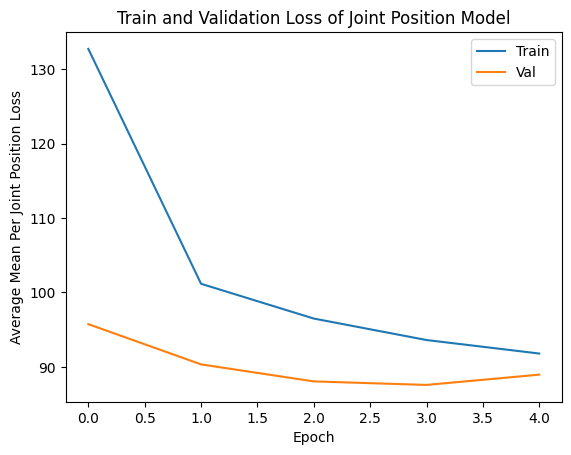

[Epoch: 6, Iteration:     1]  training loss: 93.711
[Epoch: 6, Iteration:   201]  training loss: 93.577
[Epoch: 6, Iteration:   401]  training loss: 92.203
[Epoch: 6, Iteration:   601]  training loss: 87.554
[Epoch: 6, Iteration:     1]  validation loss: 87.077
[Epoch: 7, Iteration:     1]  training loss: 91.786
[Epoch: 7, Iteration:   201]  training loss: 91.994
[Epoch: 7, Iteration:   401]  training loss: 86.191
[Epoch: 7, Iteration:   601]  training loss: 91.381
[Epoch: 7, Iteration:     1]  validation loss: 84.133
[Epoch: 8, Iteration:     1]  training loss: 92.598
[Epoch: 8, Iteration:   201]  training loss: 90.096
[Epoch: 8, Iteration:   401]  training loss: 87.315
[Epoch: 8, Iteration:   601]  training loss: 89.478
[Epoch: 8, Iteration:     1]  validation loss: 82.519
[Epoch: 9, Iteration:     1]  training loss: 85.556
[Epoch: 9, Iteration:   201]  training loss: 91.023
[Epoch: 9, Iteration:   401]  training loss: 85.024
[Epoch: 9, Iteration:   601]  training loss: 85.382
[Epoch

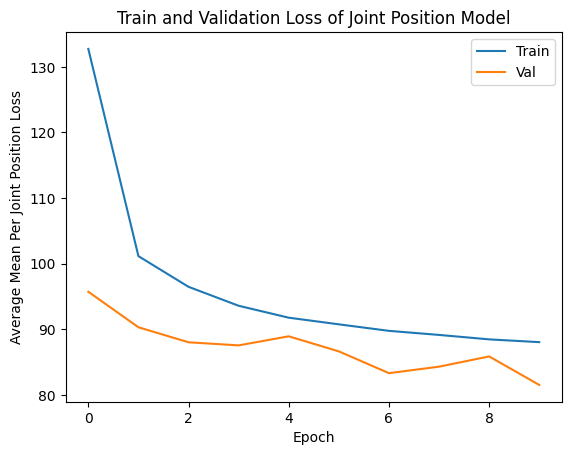

[Epoch: 11, Iteration:     1]  training loss: 87.636
[Epoch: 11, Iteration:   201]  training loss: 81.103
[Epoch: 11, Iteration:   401]  training loss: 87.422
[Epoch: 11, Iteration:   601]  training loss: 85.773
[Epoch: 11, Iteration:     1]  validation loss: 83.514
[Epoch: 12, Iteration:     1]  training loss: 78.588
[Epoch: 12, Iteration:   201]  training loss: 86.458
[Epoch: 12, Iteration:   401]  training loss: 80.235
[Epoch: 12, Iteration:   601]  training loss: 81.177
[Epoch: 12, Iteration:     1]  validation loss: 76.898
[Epoch: 13, Iteration:     1]  training loss: 77.253
[Epoch: 13, Iteration:   201]  training loss: 85.594
[Epoch: 13, Iteration:   401]  training loss: 80.023
[Epoch: 13, Iteration:   601]  training loss: 84.307
[Epoch: 13, Iteration:     1]  validation loss: 79.458
[Epoch: 14, Iteration:     1]  training loss: 80.379
[Epoch: 14, Iteration:   201]  training loss: 82.780
[Epoch: 14, Iteration:   401]  training loss: 86.311
[Epoch: 14, Iteration:   601]  training 

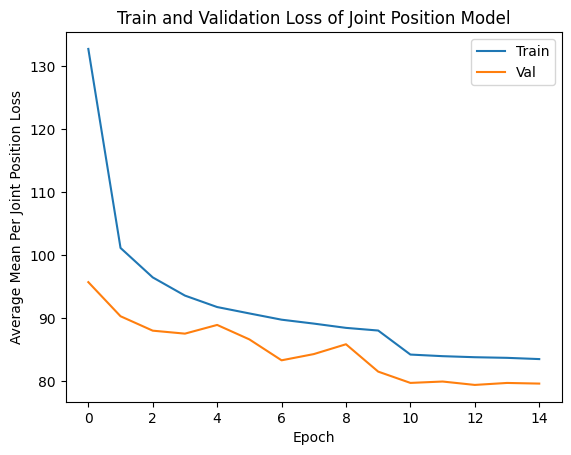

[Epoch: 16, Iteration:     1]  training loss: 83.189
[Epoch: 16, Iteration:   201]  training loss: 78.421
[Epoch: 16, Iteration:   401]  training loss: 84.159
[Epoch: 16, Iteration:   601]  training loss: 84.799
[Epoch: 16, Iteration:     1]  validation loss: 81.502
[Epoch: 17, Iteration:     1]  training loss: 84.119
[Epoch: 17, Iteration:   201]  training loss: 84.477
[Epoch: 17, Iteration:   401]  training loss: 82.300
[Epoch: 17, Iteration:   601]  training loss: 81.650
[Epoch: 17, Iteration:     1]  validation loss: 80.023
[Epoch: 18, Iteration:     1]  training loss: 82.570
[Epoch: 18, Iteration:   201]  training loss: 81.605
[Epoch: 18, Iteration:   401]  training loss: 83.780
[Epoch: 18, Iteration:   601]  training loss: 83.900
[Epoch: 18, Iteration:     1]  validation loss: 77.262
[Epoch: 19, Iteration:     1]  training loss: 84.548
[Epoch: 19, Iteration:   201]  training loss: 86.037
[Epoch: 19, Iteration:   401]  training loss: 84.736
[Epoch: 19, Iteration:   601]  training 

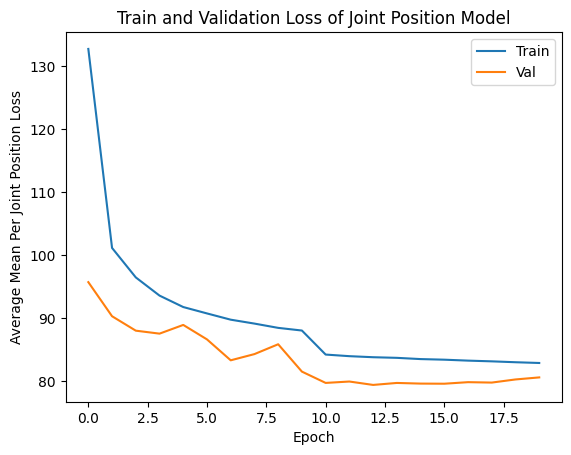

[Epoch: 21, Iteration:     1]  training loss: 81.031
[Epoch: 21, Iteration:   201]  training loss: 83.989
[Epoch: 21, Iteration:   401]  training loss: 83.444
[Epoch: 21, Iteration:   601]  training loss: 83.535
[Epoch: 21, Iteration:     1]  validation loss: 80.700
[Epoch: 22, Iteration:     1]  training loss: 83.056
[Epoch: 22, Iteration:   201]  training loss: 82.624
[Epoch: 22, Iteration:   401]  training loss: 84.092
[Epoch: 22, Iteration:   601]  training loss: 81.711
[Epoch: 22, Iteration:     1]  validation loss: 82.931
[Epoch: 23, Iteration:     1]  training loss: 81.719
[Epoch: 23, Iteration:   201]  training loss: 85.790
[Epoch: 23, Iteration:   401]  training loss: 83.891
[Epoch: 23, Iteration:   601]  training loss: 77.325
[Epoch: 23, Iteration:     1]  validation loss: 83.700
[Epoch: 24, Iteration:     1]  training loss: 84.370
[Epoch: 24, Iteration:   201]  training loss: 80.901
[Epoch: 24, Iteration:   401]  training loss: 82.474
[Epoch: 24, Iteration:   601]  training 

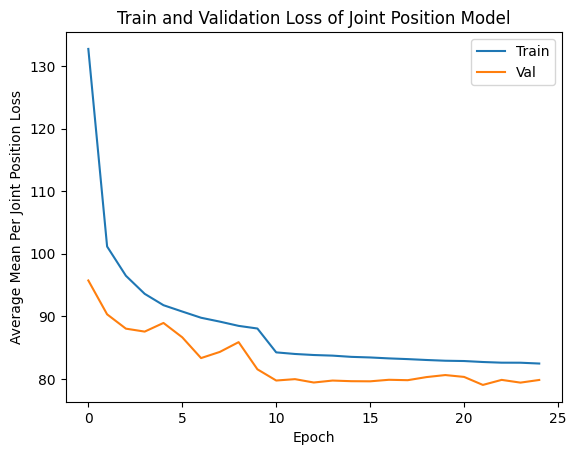

[Epoch: 26, Iteration:     1]  training loss: 79.736
[Epoch: 26, Iteration:   201]  training loss: 80.373
[Epoch: 26, Iteration:   401]  training loss: 78.077
[Epoch: 26, Iteration:   601]  training loss: 82.744
[Epoch: 26, Iteration:     1]  validation loss: 77.749
[Epoch: 27, Iteration:     1]  training loss: 79.057
[Epoch: 27, Iteration:   201]  training loss: 83.084
[Epoch: 27, Iteration:   401]  training loss: 82.879
[Epoch: 27, Iteration:   601]  training loss: 80.790
[Epoch: 27, Iteration:     1]  validation loss: 75.605
[Epoch: 28, Iteration:     1]  training loss: 86.333
[Epoch: 28, Iteration:   201]  training loss: 83.514
[Epoch: 28, Iteration:   401]  training loss: 82.725
[Epoch: 28, Iteration:   601]  training loss: 80.780
[Epoch: 28, Iteration:     1]  validation loss: 79.160
[Epoch: 29, Iteration:     1]  training loss: 83.261
[Epoch: 29, Iteration:   201]  training loss: 79.500
[Epoch: 29, Iteration:   401]  training loss: 81.290
[Epoch: 29, Iteration:   601]  training 

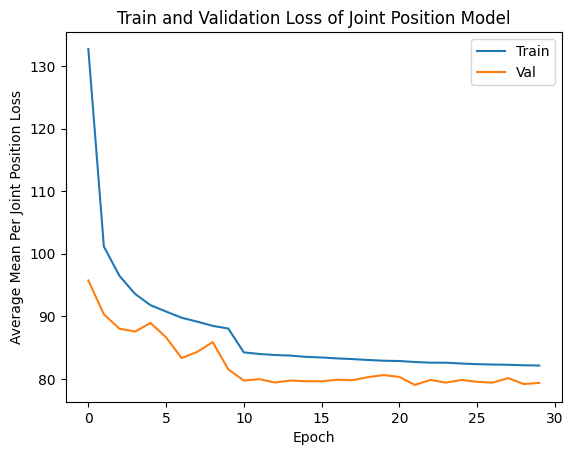

[Epoch: 31, Iteration:     1]  training loss: 86.961
[Epoch: 31, Iteration:   201]  training loss: 77.131
[Epoch: 31, Iteration:   401]  training loss: 78.146
[Epoch: 31, Iteration:   601]  training loss: 82.861
[Epoch: 31, Iteration:     1]  validation loss: 81.395
[Epoch: 32, Iteration:     1]  training loss: 85.846
[Epoch: 32, Iteration:   201]  training loss: 79.568
[Epoch: 32, Iteration:   401]  training loss: 80.945
[Epoch: 32, Iteration:   601]  training loss: 79.844
[Epoch: 32, Iteration:     1]  validation loss: 81.662
[Epoch: 33, Iteration:     1]  training loss: 74.860
[Epoch: 33, Iteration:   201]  training loss: 81.041
[Epoch: 33, Iteration:   401]  training loss: 79.938
[Epoch: 33, Iteration:   601]  training loss: 79.633
[Epoch: 33, Iteration:     1]  validation loss: 80.755
[Epoch: 34, Iteration:     1]  training loss: 81.569
[Epoch: 34, Iteration:   201]  training loss: 84.993
[Epoch: 34, Iteration:   401]  training loss: 81.967
[Epoch: 34, Iteration:   601]  training 

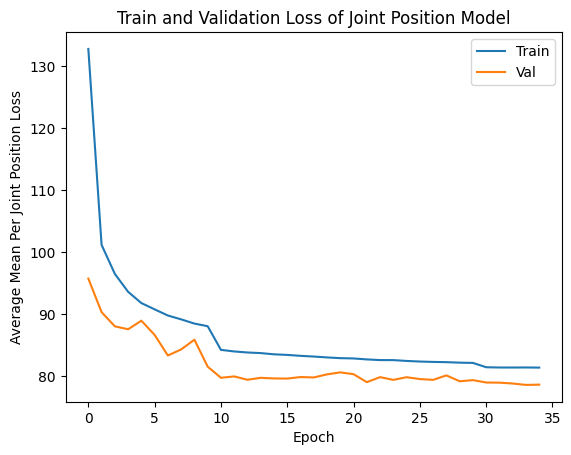

[Epoch: 36, Iteration:     1]  training loss: 77.363
[Epoch: 36, Iteration:   201]  training loss: 84.272
[Epoch: 36, Iteration:   401]  training loss: 84.007
[Epoch: 36, Iteration:   601]  training loss: 83.965
[Epoch: 36, Iteration:     1]  validation loss: 78.956
[Epoch: 37, Iteration:     1]  training loss: 88.913
[Epoch: 37, Iteration:   201]  training loss: 82.517
[Epoch: 37, Iteration:   401]  training loss: 81.158
[Epoch: 37, Iteration:   601]  training loss: 85.807
[Epoch: 37, Iteration:     1]  validation loss: 81.622
[Epoch: 38, Iteration:     1]  training loss: 84.710
[Epoch: 38, Iteration:   201]  training loss: 80.087
[Epoch: 38, Iteration:   401]  training loss: 81.569
[Epoch: 38, Iteration:   601]  training loss: 84.383
[Epoch: 38, Iteration:     1]  validation loss: 78.214
[Epoch: 39, Iteration:     1]  training loss: 81.503
[Epoch: 39, Iteration:   201]  training loss: 81.877
[Epoch: 39, Iteration:   401]  training loss: 80.072
[Epoch: 39, Iteration:   601]  training 

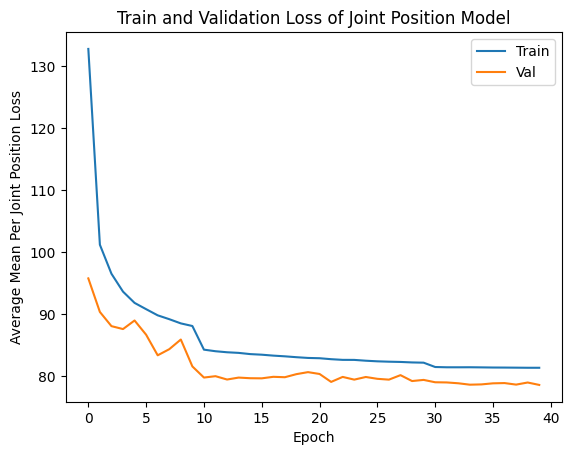

In [25]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

# launch training
train(data_loader,vald_loader, path_to_save_model=model_path)

## Test Loop

After training and validation, the test loop is the final phase that evaluates the model's performance on an entirely independent dataset known as the test dataset. This dataset is distinct from the training and validation data, ensuring unbiased assessment. The test loop provides a reliable estimate of how well the model will perform in real-world scenarios, confirming that any improvements observed during training and validation are not due to overfitting or chance. It's a crucial step before deploying the model in practical applications.

In [10]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print(f'model loaded from {ckpt_path}')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict

          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,output_n,32,3),sequences_gt.view(-1,output_n,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)


*Note: Your results should be better than 95 millimiters on average*

In [12]:
ckpt_path = './checkpoints/model_params_epoch_39.pt' # Change the epoch according to the validation curve
test(ckpt_path)

model loaded from ./checkpoints/model_params_epoch_39.pt


C:\Users\Jonas\Desktop\Uni\MSc\Year-2\AML\Assignments\aml-2023-assignment-3\Practice\utils\h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  61.8
eating :  60.7
smoking :  59.7
discussion :  86.5
directions :  79.6
greeting :  102.3
phoning :  74.7
posing :  113.6
purchases :  101.3
sitting :  85.6
sittingdown :  111.8
takingphoto :  86.9
waiting :  81.3
walkingdog :  112.5
walkingtogether :  59.7
Average: 85.2
Prediction time:  0.018276502688725788


## Human Pose Visualization  (**2 Points**)

The qualitative results are as important as the quantitative ones. In this section, you will visualize and compare the predicted poses with the ground truth ones.
For simplicity, you will visualize only the first predicted pose and the ground truth.

Ideally, the same plot should show the predicted pose in red and the ground truth one in green.

*Note: you will find which nodes are connected in the file ./models/skeleton_connection.py*

In [36]:
def first_pose(model_state_dict_path: str):
    """Gets the first predicted and ground truth pose from the test data.

    Loads the model from the given path and does the prediction.

    :arg
    model_state_dict_path (str): the full path to the state dict of the model for which to obtain the first prediction and ground truth pair.
    :return
    ()
    """
    model.load_state_dict(torch.load(model_state_dict_path))
    print(f'model loaded from: {model_state_dict_path}')

    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0

    for action in actions:
        running_loss=0
        n=0
        dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])

        test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
        for cnt, batch in enumerate(test_loader):
            with torch.no_grad():

                batch = batch.to(device)
                batch_dim = batch.shape[0]
                n += batch_dim

                all_joints_seq_predict = batch.clone()[:, input_n:input_n+output_n,:]

                sequences_train = batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
                sequences_gt = batch[:, input_n:input_n+output_n, :]

                running_time = time.time()
                sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)

                totalll += time.time()-running_time
                counter += 1
                sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

                all_joints_seq_predict[:,:,dim_used] = sequences_predict
                all_joints_seq_predict[:,:,index_to_ignore] = all_joints_seq_predict[:,:,index_to_equal]

                # the dimensions are (batch, frame, joint, xyz coord) so we return the first frame of the first batch
                return all_joints_seq_predict[0, 0].reshape(32, 3), sequences_gt[0, 0].reshape(32, 3)

In [37]:
pred, truth = first_pose(ckpt_path)

model loaded from: ./checkpoints/model_params_epoch_39.pt


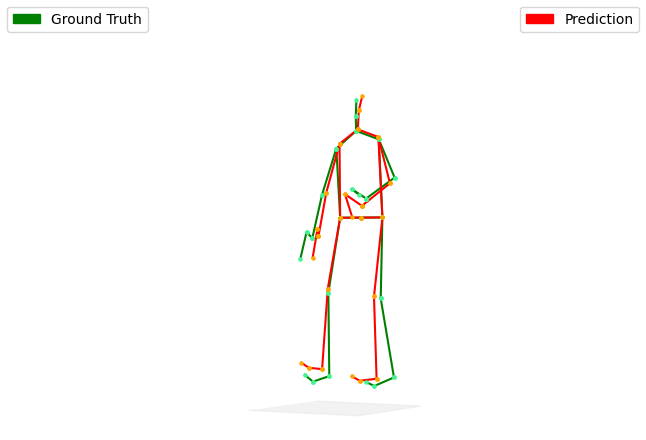

In [56]:
import matplotlib.patches
from utils import skeleton_connections

def plot_skeleton(joints, fig=None, ax=None, **kwargs):
    """Plots the provided joints in a 3D space and returns the figure and axes object.

    Joints will be represented with circles and connected with straight lines. If a fig and ax object are provided, the joints will be plotted on it.

    :arg
        joints (torch.Tensor): a torch tensor of shape (j, d) where j are the joints and d are the 3 spatial dimensions.
        fig (plt.Figure): a pyplot figure on which to plot the joints.
        ax (plt.Axes): pyplot axes on which to plot the joints.

    :return
        fig, ax: a figure and axis object with the plotted joints.
    """
    if not fig:
        fig = plt.figure()

    if not ax:
        ax = fig.add_subplot(111, projection='3d')

    joint_line_colour = kwargs.get("joint_line_colour", "r")
    joint_colour = kwargs.get("joint_colour", "orange")

  # tells me which joints to connect, I need to take the indeces and draw lines between in the space
    for joint_1, joint_2 in skeleton_connections.connect:
        x1, y1, z1 = joints[joint_1].cpu()
        x2, y2, z2 = joints[joint_2].cpu()

        ax.plot((x1, x2), (y1, y2), (z1, z2), c=joint_line_colour)

        ax.scatter(x1, y1, z1, c=joint_colour, marker='o', s=5)
        ax.scatter(x2, y2, z2, c=joint_colour, marker='o', s=5)

        ax.view_init(elev=60, azim=0, roll=90)
        # Get rid of the ticks and tick labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.set_zticklabels([])
    ax.set_aspect('equal')

    # Get rid of the panes (actually, make them white)
    white = (1.0, 1.0, 1.0, 0.0)
    ax.xaxis.set_pane_color(white)
    #ax.yaxis.set_pane_color(white)
    ax.zaxis.set_pane_color(white)

    # Get rid of the lines in 3d
    ax.xaxis.line.set_color(white)
    ax.yaxis.line.set_color(white)
    ax.zaxis.line.set_color(white)

    # manually define a new patch
    patch_label = matplotlib.patches.Patch(color=joint_line_colour, label=kwargs.get("label", ""))

    handles, labels = ax.get_legend_handles_labels()

    # remove
    handles = handles[len(skeleton_connections.connect)*2:]
    handles.append(patch_label)

    # plot the legend
    fig.legend(handles=handles, loc=kwargs.get("loc", "upper center"))

    return fig, ax

fig, ax = plot_skeleton(truth, joint_line_colour="g", joint_colour="#42f590", label="Ground Truth", loc="upper left")
fig, ax = plot_skeleton(pred, fig=fig, ax=ax, joint_line_colour="r", joint_colour="orange", label="Prediction", loc="upper right")

## Report and Parameter Fine-Tuning Analysis  (**4 Points**)

**Objective:** In this exercise, you will analyze the results obtained from a deep learning model you previously trained and perform parameter fine-tuning to optimize its performance. The key considerations are learning rate, milestones, and weight decay. **You will also use tables and plots to visualize and interpret the outcomes.**

**Instructions:**

1. **Analysis:** Analyze the generated report and answer the following questions:
   - Is there evidence of overfitting or underfitting in the initial training results?
   - Are there fluctuations in training and validation loss or accuracy? If so, what might be causing them?
   - What can you infer from the initial learning rate, milestones, and weight decay settings?

2. **Parameter Fine-Tuning:** Based on your analysis, perform parameter fine-tuning to optimize model performance. Adjust the following parameters:
   - **Learning Rate:** Experiment with different learning rates (higher and lower values) to find an optimal rate.
   - **Milestones:** Modify the milestone values for adjusting the learning rate schedule.
   - **Weight Decay:** Explore different weight decay values.
   

3. **Re-Training:** Train the model with the adjusted hyperparameters. Record the training progress and generate a new report, including performance metrics and line plots as before.

4. **Final Analysis:** Analyze the results of the fine-tuned model and compare them with the initial training. Answer the following questions:
   - Has parameter fine-tuning improved model performance?
   - Did it mitigate overfitting or underfitting issues?
   - What can you conclude about the optimal hyperparameters for this task?


## Calculating MPJPE for a Specific Frame  (**2 Points**)


In this exercise, you will calculate the Mean Per Joint Position Error (MPJPE) for a specific frame. This skill is valuable for assessing the accuracy of your model's predictions at a particular moment.

\begin{align*}
\text{MPJPE}_t = \frac{1}{N} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|
\end{align*}

Fixed the frame $t$, you will calculate the MPJPE for the predicted pose and the ground truth. Steps:

- Write a function that takes in input the predicted pose and the ground truth one and returns the MPJPE for a number of frames $t$. (e.g. the output could be a dictionary with the frame number as key and the MPJPE as value)
- Rewrite the test function to use the function you just wrote.
- Run the newly created test function for $t=[5, 10, 15, 25]$ and report the results in a table and plot.





In [61]:
def mpjpe_per_frame(sequences_predict, sequences_gt, frames_to_consider=None):
    """For a specific sequence, calculates the Mean Per Joint Position Error (MPJPE).

    The MPJPE assesses the prediction at particular moment in time time. It is the average euclidean distance between the predicted and true joint position, over all predicted joints.

    :arg
      sequences_predict (torch.Tensor): the predicted joint positions. Has shape (batch, frame, joint, joint xyz coordinate).
      sequences_gt (torch.Tensor): the ground truth joint positions. Has shape (batch, frame, joint, joint xyz coordinate).
      frames_to_consider (Iterable): an iterable of integers for the frames to calculate the MPJPE for. If not provided, all frames will be considered.

    :return
      (dict) a dictionary where keys are frame numbers and values are MPJPE scores.
    """
    mpjpe = {}
    if not frames_to_consider:
      print("No frames provided, considering all frames.")
      frames_to_consider = range(sequences_predict.shape[0])

    # reshape the sequences into (batch, frame, joint, joint xyz coord)
    sequences_predict = sequences_predict.view(*sequences_predict.shape[:-1], sequences_predict.shape[-1] // 3, 3)
    num_predicted_joints = sequences_predict.shape[-2]
    sequences_gt = sequences_gt.view(*sequences_gt.shape[:-1], sequences_gt.shape[-1] // 3, 3)
    sequences_gt = sequences_gt[:, :, :num_predicted_joints, :]

    # TODO need to take into account the batch dimension
    for frame in frames_to_consider:

      # extract the prediction and ground truth frame, they will have shapes (joint, xyz coordinate)
      predict_frame, gt_frame = sequences_predict[frame], sequences_gt[frame]

      # calculate the pairwise euclidean distance between the each pair of joints
      distance = torch.nn.PairwiseDistance(p=2)(predict_frame, gt_frame)

      # take the average
      mpjpe[frame] = distance.mean().item()

    return mpjpe

In [62]:
def test_per_frame(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          '''
          Insert your code below.
          The function mpjpe_per_frame should return the loss for each frame in the sequence. (e.g. a dictionary with keys the frames and values the loss for each frame)
          Keep a tab of the running loss for each frame and the number of frames in the sequence.
          '''
          frames_to_consider = [5, 10, 15, 25]
          dict_loss=mpjpe_per_frame(sequences_predict, sequences_gt, frames_to_consider)



      '''
      Insert your code below.
      Average the loss over all the frames in the sequence and print the results.
      '''
      # TODO: here we should consider all frames then? a bit unsure about the instructions


In [63]:
'''
Insert your code below where you want to load the model and test it.
You need to specify the path to the model checkpoint file and call the test function.
'''
#ckpt_path = ""
test_per_frame(ckpt_path)

model loaded


IndexError: index 10 is out of bounds for dimension 0 with size 8

## Iterative Mechanism (**3 Points**)

In this exercise, you will explore the concept of an iterative mechanism and its adaptability when the model's output length changes. You will start with a model designed to produce 25 output frames but adapt it to generate only 10. The exercise will involve modifying and re-training the model for the new output length. During test time, the model will generate 10 frames and then use them as input to generate the successive 10 frames, and so on, until the desired number of frames is reached. In this case, you are asked to generate 25 frames.

The steps are as follows:
- Change the model's output length from 25 to 10.
- Re-train the model.
- Rewrite the test function to generate 25 frames using the iterative mechanism.
- Generate a new report and compare the results to the baseline model.

In [ ]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './checkpoints/'
input_n=10 # number of frames to train on (default=10)

'''
Insert your code below
'''
output_n= ... # number of frames to predict on

input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22

#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path_iterative= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2


In [ ]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

In [ ]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

In [ ]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

### Train and Validation Loop

In [ ]:
save_and_plot = False # save the model and plot the loss. Change to True if you want to save the model and plot the loss

In [ ]:
# launch training with the new output_n
train(data_loader,vald_loader, path_to_save_model=model_path_iterative)

### Test Loop

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          '''
          Insert your code below. You will need to iteratively predict the next frames and feed it to back to the model until you reach the desired number of frames.
          '''


In [ ]:
test(ckpt_path=model_path_iterative)

## YOUR custom model (**3 Points**)
 In this exercise, you will implement a Transformer-like network (based on the Theory notebook) for this specific task. You can use the Transformer's Encoder and implement your own Decoder to predict future poses. (e.g. RNN, MLP, CNN, TCN, ...).
 We won't provide any code for this exercise, but you can use the code provided in the Theory notebook as a starting point.
 The goal of this exercise is not to beat the previous model but to understand how to implement a Transformer network for this specific task. For this reason, the evaluation will be based on the code you write and the explanation you provide in the report rather than the results.


### Performance BONUS (**Up to 2 Points**)
- **1 Bonus Point** if the model achieves an A-MPJPE between 80 and 90 millimeters.
- **2 Bonus Points** if the model achieves an A-MPJPE between 70 and 80 millimeters.


In [ ]:
'''
Input Shape: [batch_size, input_time, joints, 3]

Encoder:
Input shape: [batch_size, input_time, joints, 3]
Output shape: [batch_size, input_time/output_time, joints, FREE]

# Decoder:
Input shape: [batch_size, input_time/output_time, joints, FREE]
Output shape: [batch_size, output_time, joints, 3]


Hint: Transformers often take an input of shape [batch_size, time, joints*channels], use the reshape or view function to match the dimensionality.
'''